In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, JLD2

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


### data prep

In [6]:
# load data
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)
pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"];

In [16]:
D1, τ1, E1 = optimal_separated_de(pc1)
D2, τ2, E2 = optimal_separated_de(pc2);

D1, D2 = Matrix(transpose(Matrix(D1))), Matrix(transpose(Matrix(D2)));

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [17]:
size(D1,2), size(D2,2)

(12519, 12519)

In [18]:
size(D1,1), size(D2,1)

(8, 8)

In [33]:
train_size = 10000
val_size = 2000
test_size = size(D1,2) - train_size - val_size

519

In [50]:
train_pc1, train_pc2 = D1[:, 1:train_size],  D2[:, 1:train_size]
val_pc1, val_pc2 = D1[:, train_size+1:train_size+val_size], D2[:, train_size+1:train_size+val_size]
test_pc1, test_pc2 = D1[:, train_size+val_size+1:train_size+val_size+test_size], D2[:, train_size+val_size+1:train_size+val_size+test_size];

### training

In [51]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
esn_pc1, W_out_pc1, val_loss_pc1 = enso_project.cross_validate_esn(train_pc1, val_pc1, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15044.143070206772
enso_project.ESNHyperparams(500, 0.8, 0.5, 0.1, 0.0)
Validation loss = 14028.332117730697


(ESN(8 => 500), OutputLayer successfully trained with output size: 8, 14028.332117730697)

In [52]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
esn_pc2, W_out_pc2, val_loss_pc2 = enso_project.cross_validate_esn(train_pc2, val_pc2, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 11115.251050486528
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 10071.460218223527
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 10070.720541312765


(ESN(8 => 500), OutputLayer successfully trained with output size: 8, 10070.720541312765)

### evaluate prediction

In [53]:
prediction_pc1 = enso_project.esn_eval_pred(esn_pc1, W_out_pc1, test_pc1)
prediction_pc2 = enso_project.esn_eval_pred(esn_pc2, W_out_pc2, test_pc2);

### plot

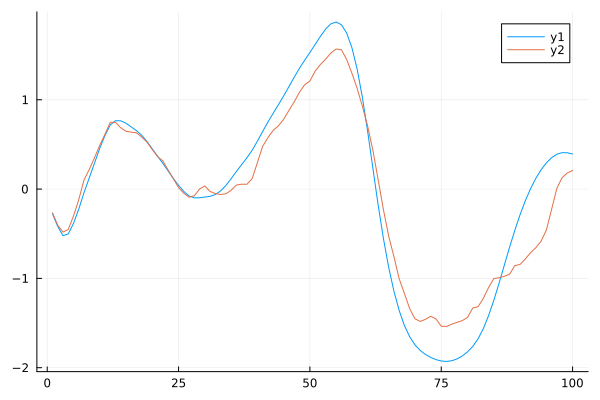

In [59]:
plot(prediction_pc1[1:100])
plot!(test_pc1[1,1:100])

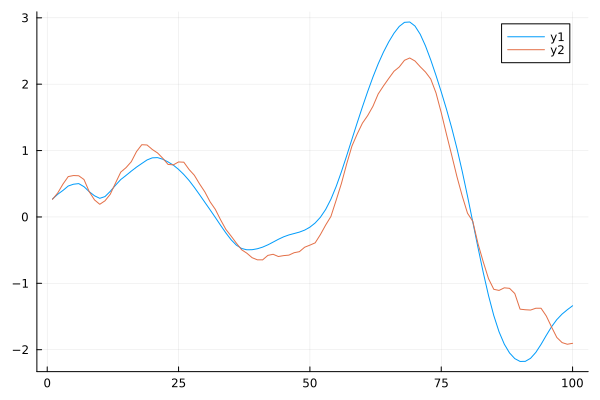

In [61]:
plot(prediction_pc2[1:100])
plot!(test_pc2[1,1:100])

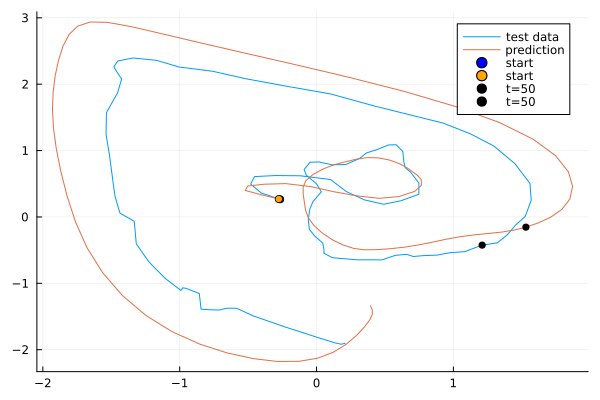

In [60]:
plot(test_pc1[1,1:100], test_pc2[1,1:100], label="test data")
plot!(prediction_pc1[1:100], prediction_pc2[1:100], label="prediction")
scatter!([test_pc1[1,1]], [test_pc2[1,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction_pc1[1]], [prediction_pc2[1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([test_pc1[1,50]], [test_pc2[1,50]], label="t=50", color=:black, marker=:circle, markersize=4)
scatter!([prediction_pc1[50]], [prediction_pc2[50]], label="t=50", color=:black, marker=:circle, markersize=4)